# Табличные GAN

Цели:

* познакомиться с "первым поколением" табличных GAN
* рассмотреть способы подготовки табличных данных для генеративных моделей

Содержание:

* Загрузка данных
  * Лёгкий EDA
* Особенности табличных GAN
  * Постановка задачи
  * Нормализация по модам
    * Пример нормализации
  * Условная генерация
    * Условный вектор
    * Функция потерь генератора
    * Обучение с сэмплированием
  * Архитектура сетей CTGAN, TVAE
  * Оценка качества
* Обучение моделей
* Анализ результатов
  * Распределения
  * Оценка качества TSTR
* CTAB-GAN
* Заключение
* Упражнения

Ссылки:

* [датасет по MOOC](https://huggingface.co/datasets/sswt/stanford-act-mooc)
* [Modeling Tabular data using Conditional GAN](https://arxiv.org/pdf/1907.00503.pdf)


In [1]:
!pip install -q sdv
# !pip install -U -q ctgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN, TVAE

## Загрузка данных

Данные представляют лог действий пользователей на популярной MOOC-площадке, с  временной меткой, категориальным и числовыми атрибутами. Есть также переменная LABEL, которая представляет собой бинарный флаг - бросил ли пользователь курс после этого действия, то есть было ли это действие последним для пользователя.

In [3]:
!wget -q https://huggingface.co/datasets/sswt/stanford-act-mooc/resolve/main/act-mooc.csv.gz

In [4]:
df = pd.read_csv('act-mooc.csv.gz')
print(df.shape)
df.head()

(411749, 9)


,ACTIONID,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,0,0,0,0.0,-0.319991,-0.435701,0.106784,-0.067309,0
1,1,0,1,6.0,-0.319991,-0.435701,0.106784,-0.067309,0
2,2,0,2,41.0,-0.319991,-0.435701,0.106784,-0.067309,0
3,3,0,1,49.0,-0.319991,-0.435701,0.106784,-0.067309,0
4,4,0,2,51.0,-0.319991,-0.435701,0.106784,-0.067309,0


In [5]:
df = df.drop_duplicates()
df.shape

(396712, 9)

### Лёгкий EDA

Познакомимся с данными чуть поближе, так как мы скорее всего будем их переиспользовать в следующих занятиях.

In [6]:
cat_cols = ['ACTIONID', 'USERID', 'TARGETID', 'LABEL']
num_cols = ['TIMESTAMP', 'FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']

In [7]:
df[cat_cols].nunique()

ACTIONID    396633
USERID        7047
TARGETID        97
LABEL            2
dtype: int64

In [8]:
df['LABEL'].value_counts()

0    392646
1      4066
Name: LABEL, dtype: int64

Видим, что в данных:

* число уникальных ACTIONID практически равно числу строк
* 7К пользователей
* 97 видов активности
* событий с меткой LABEL=1 около 1%

Но всё же, некоторые действия встречаются более одного раза, посмотрим на них поближе.

In [9]:
df['ACTIONID'].value_counts().value_counts()

1    396554
2        79
Name: ACTIONID, dtype: int64

In [10]:
s = df['ACTIONID'].value_counts()
s[s == 2].head(3)

103540    2
116776    2
27959     2
Name: ACTIONID, dtype: int64

In [11]:
df[df['ACTIONID'] == 103540]

,ACTIONID,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
103539,103540,4451,29,786792.0,-0.319991,2.108722,-0.394237,-0.067309,0
103540,103540,4451,29,786792.0,-0.319991,2.108722,-0.394237,-0.067309,1


Абсолютно одинаковые строки с разной меткой LABEL - модели это должно понравиться.

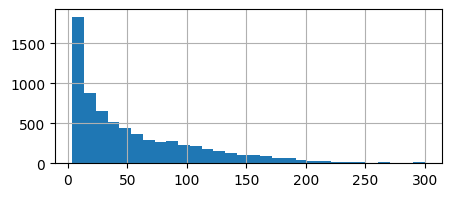

In [12]:
df['USERID'].value_counts().clip(upper=300).hist(bins=30, figsize=(5, 2));

Число событий на пользователя имеет экспоненциальное распределение с длинным хвостом. Интуитивно, пользователи с большим количеством действий должны меньше оттекать.

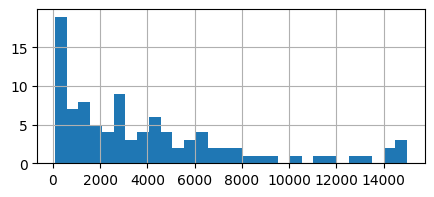

In [13]:
df['TARGETID'].value_counts().clip(upper=15000).hist(bins=30, figsize=(5, 2));

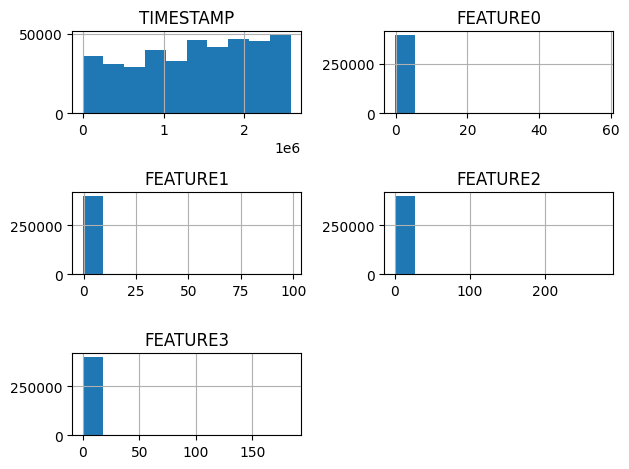

In [14]:
df[num_cols].hist()
plt.tight_layout()

Временные метки начинаются с нуля и распределены достаточно равномерно, что странно. Числовые признаки имеют очень странное распределение с ярко выраженной модой около нуля.

Посмотрим на них поближе.

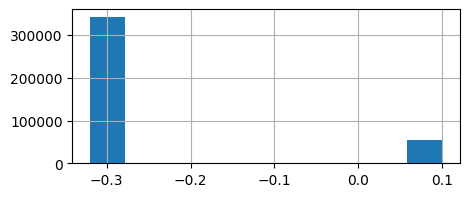

In [15]:
df['FEATURE0'].clip(upper=.1).hist(figsize=(5, 2));

In [16]:
s = df['FEATURE0'].value_counts()
s

-0.319991     342988
 1.028091      24507
 2.376173      22091
 3.724255       3055
 5.072338       2509
 7.768502        677
 6.420420        540
 9.116585        144
 10.464667       107
 13.160832        31
 11.812749        29
 14.508914        11
 17.205078         6
 15.856996         5
 22.597408         1
 23.945490         1
 25.293572         1
 30.685901         1
 29.337819         1
 21.249325         1
 38.774395         1
 42.818642         1
 44.166724         1
 57.647547         1
 27.989737         1
 45.514807         1
Name: FEATURE0, dtype: int64

In [17]:
s.index[1:] - s.index[:-1]

Float64Index([ 1.3480823000241184,  1.3480823000241184,  1.3480823000241182,
               1.3480823000241196,  2.6961646000482355, -1.3480823000241173,
               2.6961646000482364,  1.3480823000241173,   2.696164600048233,
               -1.348082300024112,  2.6961646000482347,  2.6961646000482364,
              -1.3480823000241173,   6.740411500120587,  1.3480823000241244,
               1.3480823000241244,   5.392329200096469, -1.3480823000241209,
               -8.088493800144711,  17.525069900313543,   4.044246900072345,
               1.3480823000241315,   13.48082300024118, -29.657810600530606,
               17.525069900313536],
             dtype='float64')

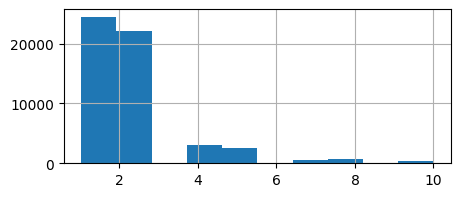

In [18]:
df['FEATURE0'][df['FEATURE0'] > 0].clip(upper=10).hist(figsize=(5, 2));

Переменная FEATURE0 имеет стабильный шаг 1.348 между значениями, как будто приведена искусственно к числовой форме.

In [19]:
df['FEATURE3'].value_counts().sort_index()

-0.067309      370043
 0.133387        8518
 0.334083        4969
 0.534779        3552
 0.735475        2360
                ...  
 149.451211         1
 151.056779         1
 161.894364         1
 174.538212         1
 183.970924         1
Name: FEATURE3, Length: 164, dtype: int64

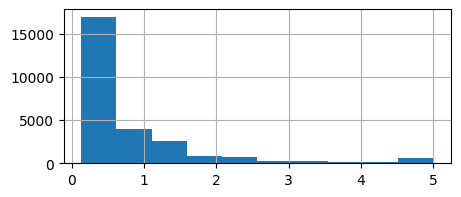

In [20]:
df['FEATURE3'][df['FEATURE3'] > 0].clip(upper=5).hist(figsize=(5, 2));

У FEATURE3 шаг уже не такой стабильный, но она не менее странная.

Проверим, всегда ли у пользователя история действий заканчивается на единице (если она есть)

In [21]:
df_chk = pd.concat([
    df.groupby('USERID')['TIMESTAMP'].max().reset_index()\
      .merge(df)[['USERID', 'LABEL']].set_index('USERID'),
    df.groupby('USERID')['LABEL'].max().rename('LABEL2')
], axis=1)
(df_chk['LABEL'] == df_chk['LABEL2']).value_counts()

True     7047
False      79
dtype: int64

In [22]:
df_chk[df_chk['LABEL'] != df_chk['LABEL2']].head(3)

,LABEL,LABEL2
USERID,,
20,0,1
47,0,1
213,0,1


In [23]:
df[df['USERID'] == 47]

,ACTIONID,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
329,329,47,1,63343.0,-0.319991,-0.435701,0.106784,-0.067309,0
331,331,47,3,63362.0,-0.319991,-0.435701,0.106784,-0.067309,0
338,338,47,4,63477.0,-0.319991,-0.435701,0.106784,-0.067309,0
339,339,47,13,63478.0,-0.319991,2.108722,-0.394237,-0.067309,0
340,340,47,3,63502.0,-0.319991,-0.435701,0.106784,-0.067309,0
341,341,47,1,63503.0,-0.319991,-0.435701,0.106784,-0.067309,0
61450,61450,47,10,429304.0,-0.319991,-0.435701,0.106784,-0.067309,0
61451,61451,47,4,429331.0,-0.319991,-0.435701,0.106784,-0.067309,0
61511,61512,47,15,429797.0,-0.319991,2.108722,-0.394237,-0.067309,0
61512,61512,47,15,429797.0,-0.319991,2.108722,-0.394237,-0.067309,1


Практически всегда это так, за исключением тех случаев, когда одинаковый timestamp в конце, это как раз те одинаковые строки, что мы встретили ранее

#### Выводы

* в датасете ~400К действий, 7К пользователей и окола 100 видов активности
* TIMESTAMP начинается с нуля и доходит до 2М
* FEATUREX - формально непрерывные столбцы, но дискретизованы с определённым шагом
* есть небольшое количество неоднозначных записей с одинаковыми атрибутами, но разными LABEL

## Особенности табличных GAN

Одной из первых была [TableGAN](https://arxiv.org/pdf/1806.03384.pdf) в 2018 году, где применили к таблицам DCGAN (свёрточная сеть 😲). Для этого строки таблицы заполнялись нулями до нужного размера и преобразовывались в квадратную матрицу, а дискретные колонки рассматривались как непрерывные. Ещё одно отличие - добавление дополнительной сети бинарного классификатора для сгенерированных строчек. Для этого бралась какое-то готовое поле с меткой класса, если оно уже содержится в данных, либо такое поле добавлялось искусственно (например, "Зарплата больше медианной"). Это в итоге позволяет помочь модели с тем, чтобы не генерировать несовместимые наборы атрибутов.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/TableGAN.png" alt="TableGAN" width="100%">
<figcaption align = "center"> Image credit: TableGAN paper</figcaption>
</figure>

В 2019 появилась [Conditional Tabular GAN (CTGAN)](https://arxiv.org/pdf/1907.00503.pdf), где авторы постарались уже лучше учесть особенности табличных данных. Дальнейшая часть изложения в этом разделе построена на данной статье.

Сложности с табличными GAN:

* необходимости одновременно моделировать непрерывные и дискретные (в т.ч. категориальные) колонки
* мультимодальные распределения в непрерывных колонках
* дисбаланс значений в категориальных колонках

В CTGAN ввели несколько новых техник:

* нормализация вещественных признаков по модам
* условная генерация для борьбы с дисбалансом в категориальных признаках
* сэмплирование при обучении для категориальных признаков

### Постановка задачи

Пусть таблица $T$ содержит $N_c$ непрерывных $\{C_1, . . . , C_{N_c}\}$ и $N_d$ дискретных $\{D_1, . . . , D_{N_d}\}$ столбцов, где каждый столбец рассматривается как случайная величина. Эти СВ распределены в соответствии с некоторым неизвестным совместным распределением $P(C_{1:N_c} , D_{1:N_d})$. Мы хотим сгенерировать таблицу $T_{syn}$, строчки которой будут соответствовать тому же распределению.

Строчка таблицы представляет собой одно наблюдение из совместного распределения:
$$r_j = \{c_{1,j}, ..., c_{N_c,j}, d_{1,j}, ..., d_{N_d,j}\}, j ∈ \{1, ... , n\} \tag 1$$

### Нормализация по модам

В картинках пиксели распределены похожим на нормальное распределение, что можно нормализовать в интервал $[-1,1]$ с помощью min-max трансформации. При этом в последнем слое обычно используется tanh, чтобы выдавать значения в этом диапазоне.

В то время как в таблицах непрерывные колонки обычно не гауссовские и использование min-max приводит к проблеме исчезающих градиентов.

Кроме того в реальных табличных датасетах часто встречаются мультимодальные распределения, а у ванильных GAN с этим проблемы.

Для мультимодальных распределений используется специальный тип нормализации (mode-specific), который состоит из трёх шагов:

1. Используется вариационная модель смеси гауссовских распределений (VGM) для определения числа мод $m_i$ и подбора параметров гауссовской смеси. Максимальное число компонент смеси задаётся равным 10.
  Например, на рисунке ниже VGM определил три моды - $\eta_1, \eta_2, \eta_3$. Подобранная гауссовская смесь
  $$P_{C_i}(c_{i,j}) = \sum_{k=1}^{3} \mu_k \mathcal N(c_{i,j}; \eta_k, \phi_k),$$где $\phi_k$ - стандартное отклонение моды, $\mu_k$ - коэффициент компоненты в смеси с ограничением $\sum_{k=1}^{K} \mu_k = 1$
2.  Для каждого уникального значения в колонке считается вероятность, что значение получено из конкретной моды. Например, на рисунке ниже вероятности $\rho_1, \rho_2, \rho_3$, которые вычисляются как $\rho_k = \mu_k \mathcal N(c_{i,j}; \eta_k, \phi_k)$
3. Сэмплируем одну моду из полученного распределения и нормализуем значение с использованием этой моды. Например, на рисунке ниже мы сэмплировали третью моду. Тогда мы представляем $c_{i,j}$ как one-hot вектор $\beta_{i,j}=[0,0,1]$ и скаляр $\alpha_{i,j}=\frac{c_{i,j} - \eta_3}{4 \phi_3}$ в качестве значения внутри моды.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_figure1.png" alt="CTGAN_figure1" width="80%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>

То есть для каждой числовой колонки номер моды кодируется one-hot вектором $β_{i, j}$ (от 1 до 10), а распределение числового признака становится ближе к нормальному. Ниже будет пример на нашем датасете.

Категориальные (дискретные) колонки $d_{i,j}$ также кодируются one-hot вектором.

Таким образом, строка  теперь представляется как конкатенация значений для непрерывных и дискретных колонок:
$$r_j = \alpha_{1,j} \oplus \beta_{1,j} \oplus \ldots \oplus \alpha_{N_c,j} \oplus \beta_{N_c,j} \oplus d_{1,j} \oplus \ldots \oplus d_{N_d,j}, \tag 2$$
где $\oplus$ - конкатенация векторов.

#### Пример нормализации

На нашем датасете, с использованием библиотеки [rdt (Reversible Data Transormations)](https://docs.sdv.dev/rdt/transformers-glossary/numerical/clusterbasednormalizer) от Datacebo (бывшая SDV)

In [24]:
from rdt.transformers.numerical import ClusterBasedNormalizer
transformer = ClusterBasedNormalizer()

In [25]:
df_smp = df.sample(frac=.2)

In [26]:
col = 'FEATURE3'
df_ft = transformer.fit_transform(df_smp, col)

In [27]:
df_ft[f'{col}.component'].value_counts().sort_index()

0.0    74044
1.0     1256
2.0     1760
3.0     1667
4.0      615
Name: FEATURE3.component, dtype: int64

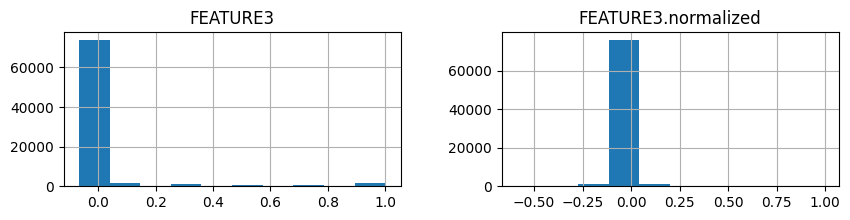

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 2))
df_smp[[col]].clip(upper=1).hist(col, ax=ax0)
df_ft.hist(f'{col}.normalized', ax=ax1);

In [29]:
col = 'TIMESTAMP'
df_ft = transformer.fit_transform(df_smp, col)

In [30]:
df_ft[f'{col}.component'].value_counts().sort_index()

0.0     4872
1.0    10373
2.0     5959
3.0     9700
4.0     7371
5.0     5612
6.0     8548
7.0    11932
8.0     8614
9.0     6361
Name: TIMESTAMP.component, dtype: int64

array([<Axes: title={'center': 'TIMESTAMP.normalized'}>], dtype=object)

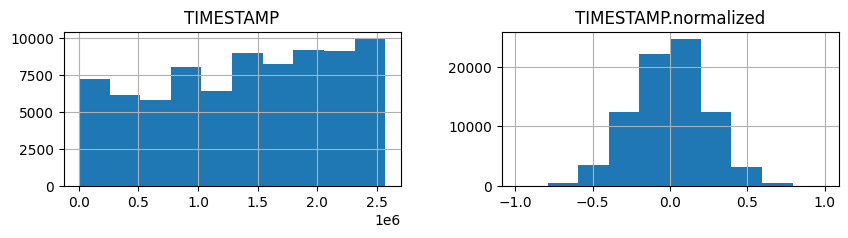

In [31]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 2))
df_smp.hist(col, ax=ax0)
df_ft.hist(f'{col}.normalized', ax=ax1)

### Условная генерация

Также есть проблема с редкими значениями категорий при обучении. В обычном машинном при дисбалансе классов обучении иногда применяют resampling, когда редкую категорию сэмплируют чаще, но здесь это не поможет, так как при этом мы сместим распределение данных. В случае табличных данных ситуация обостряется, так как есть ещё совместное распределение нескольких категориальных колонок.
Эффективный в данном случае resampling - добиться того, чтобы все категории из дискретных колонок сэмплировались равновероятно (но необязательно равномерно) в ходе обучения и восстановить реальное распределение в ходе генерации.

Пусть $k^*$ - значение из $i^*$-й дискретной колонки $D_{i^*}$, которое должно воспроизводиться с сгенерированных строках $\hat r$, тогда генератор можно интерпретировать как условное распределение строк при данном значении данной колонки, то есть $\hat r \sim P_G(row | D_{i^*} = k^*)$. Исходя из этих соображений, в этой работе он называется условным генератором.

Условный генератор должен научиться реальному условному распределению данных, то есть $P_G (r | D_{i^*} = k^*) = P(r | D_{i^*} = k^*)$ для того чтобы мы могли восстановить исходное распределение как

$$P(r) = \sum_{k \in D_{i^*}} P_G (r | D_{i^*} = k^*)) P(D_{i^*} = k).$$

В CTGAN предложили решение, которое состоит из трех ключевых элементов:
* условного вектора
* функции потерь генератора
* обучения сэмплированием

#### Условный вектор

У нас каждому категориальному столбцу $d_i$ соответствует one-hot вектор и дополнительно вводим маску $m_i$ такой же длины

$$
  m_i^{(k)}=\begin{cases}
    1, & \text{if $i=i^*$ and $k=k^*$}.\\
    0, & \text{otherwise}.
  \end{cases}
$$

Условный вектор получается путём конкатенации всех масок  $cond = m_1 \oplus \ldots \oplus m_{N_d}$, где 1 равно **только одно значение**. Ниже на картинке показан пример.

#### Функция потерь генератора

В ходе обучения условный генератор никак не ограничивается и он может генерировать как лишние единички, так и 0 на нужной позиции. Для того, чтобы генерировались значения в соответствии с маской, добавляется дополнительный лосс кросс-энтропии между $m_{i^*}$ и $\hat d_{i^*}$ с усреднением по батчу. Таким образом, в ходе обучения, генератор выучивается делать точную копию маски в $\hat d_{i^*}$.


#### Обучение с сэмплированием

Выход условного генератора подаётся на вход критика, который оценивает расстояние между выученным условным распределением $P_G(r|cond)$ и условным распределением на реальных данных  $P(r|cond)$. Нужен правильный механизм сэмплирования условных векторов при обучении, для того, чтобы модели равновероятно встречались все возможные значения в дискретных колонках.

1. Случайно выбираем колонку с одинаковой вероятностью.
3. Определяем распределение вероятностей по всем значениям в колонке как $log$ частоты встречаемости и сэмплируем конкретное значение в соответствии с этим распределением.
5. Маски для всех колонок, инициализируем нулями и проставляем один компонент, соответствующий сэмплированному значению выбранной колонки, равным 1

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_figure2.png" alt="CTGAN_figure2" width="80%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>


### Архитектура сетей

#### CTGAN

##### Generator

В генераторе два полносвязных скрытых слоя с ReLU. После них генерируется уже строка - скалярные значения $α_i$ генерируются с помощью $tanh$-активации, а индикаторы моды $β_i$ и дискретные колонки $d_i$ с помощью Gumbel softmax.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_CTGAN_generator.png" alt="CTGAN generator arch" width="60%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>

##### Discriminator (Critic)

В дискриминаторе тоже два полносвязных скрытых слоя, но с Leaky ReLU. Для того, чтобы избежать коллапса (mode collapse) используется фреймворк PacGAN с 10 образцами в каждом "пакете" $C(r_1, . . . , r_{10}, cond_1, . . . , cond_{10})$. Идея PacGAN состоит в том, чтобы "упаковать" или сконкатенировать горизонтально $m$ векторов перед подачей в дискриминатор. Эти $m$ векторов сэмплируются независимо из того же распределения, либо реального с одинаковой меткой $y=1$ либо сгенерированного с меткой $y=0$. Так мы получаем произведение из $m$ распределений, что на практике позволяет избежать коллапса.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_CTGAN_critic.png" alt="CTGAN critic" width="50%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>

В качестве лосса используется WGAN + GP (поэтому критик).

P.S. В итоговых тестах WGAN + GP работал даже и без PacGAN.

#### TVAE

Для адаптации VAE к табличным данным использовали тот же препроцессинг, но модифицировали функцию потерь - назвали эту модель Tabular VAE.

TVAE состоит из двух нейросетей - декодера $p_θ (r_j |z_j)$ и энкодера $q_φ(z_j |r_j)$, которые обучаются с помощью ELBO-лосса.

##### Декодер

Сеть $p_θ (r_j |z_j)$ выдаёт совместное распределение $2N_c + N_d$ переменных, соответствующих $2N_c + N_d$ переменных $r_j$. Предполагается, что $α_{i,j}$ распределены нормально с различными средними и дисперсиями. Все $β_{i,j}$ и $d_{i,j}$ соответствуют категориальной функции распределения.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_TVAE_generator.png" alt="TVAE arch" width="90%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>

Здесь $\hat α_{i,j}$, $\hat β_{i,j}$, $\hat d_{i,j}$ - случайные величины. И $p_θ(r_j |z_j)$ их совместное распределение.

В $p_θ (r_j |z_j )$ матрицы весов и $δ_i$ - обучаемые параметры сети.

##### Энкодер

Моделирование $q_φ(z_j |r_j )$ похоже на обычный VAE.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTGAN_TVAE_critic.png" alt="TVAE arch" width="30%">
<figcaption align = "center"> Image credit: CTGAN paper</figcaption>
</figure>

В статье TVAE на нескольких датасетах превосходил CTGAN, однако по мнению авторов CTGAN как GAN не имел доступа к реальным данным, поэтому он предпочтительнее с точки зрения Differential Privacy.

### Оценка качества

#### Простые метрики

* Покрытие значений реальных данных сгенерированными, соответствие диапазонов значений
* Схожесть распределений отдельных столбцов
    * Соответствие статистик - среднее, дисперсия
    * Jensen-Shannon divergence (JSD) - расстояние между распределениями реальных и сгенерированных категориальных атрибутов, от 0 до 1 и симметрично
    * Wasserstein distance (WD) - расстояние между распределениями вещественных атрибутов, также называется Earth-Mover distance - какой объём надо перенеси отсюда-сюда, чтобы распределения стали идентичными, также от 0 до 1 для плотностей вероятности
* Сохранение взаимосвязей между атрибутами
    * Между категориальными, категориальными и непрерывными атрибутами
    * Попарная корреляция непрерывных значений

#### С помощью ML

##### Detection

Обучаем модели, смогут ли они отличить реальные данные от сгенерированных. Чем сложнее отличить, тем лучше.

##### ML efficacy

В самом начале исходная таблица $T$ случайным образом разбивается на $T_{train}$ и $T_{test}$.

Используется подход Train-on-Synthetic-Test-on-Real (TSTR):

* обучаем генеративную модель на $T_{train}$
* генерируем синтетические данные $T_{syn}$
* обучаем отдельную модель классификатора (или регрессора) на $T_{syn}$ предсказывать какой-нибудь атрибут таблицы
* проверяем точность этой модели на отложенной выборке $T_{test}$

Для опорных цифр по качеству сравнивают также с вариантом обучения на реальных данных - Train-on-Real-Test-on-Real (TRTR):
* обучаем отдельную модель классификатора (или регрессора) на $T_{train}$ предсказывать какой-нибудь атрибут таблицы
* проверяем точность этой модели на отложенной выборке $T_{test}$

Есть ещё метрики для оценки степени сохранения приватности данных, здесь они не рассматриваются.

## Обучение моделей

Некоторые реализации CTGAN:

* [От авторов статьи](https://github.com/sdv-dev/CTGAN) - раньше была организация SDV, теперь DataCebo. У этих ребят очень много внимания уделяется оценке качества результатов.
* [Улучшенная от gretel](https://docs.gretel.ai/reference/synthetics/models/gretel-actgan) - ещё одна коммерческая реализация, там улучшили скорость, потребление памяти и условную генерацию. Для категориальных столбцов с более чем 150 уникальными значениями реализован BinaryEncodingTransformer.
* [В составе пакета SynthCity](https://synthcity.readthedocs.io/en/latest/generated/synthcity.plugins.generic.plugin_ctgan.html) - от исследовательской лаборатории M. Van der Schaar

<!--
* [SDV TVAE](https://sdv.dev/SDV/user_guides/single_table/tvae.html)
* [SynthCity TVAE](https://github.com/vanderschaarlab/synthcity/blob/main/src/synthcity/plugins/core/models/tabular_vae.py)
-->

In [32]:
import os
from google.colab import userdata
from pathlib import Path
from huggingface_hub import HfApi, hf_hub_download
from sklearn.model_selection import GroupShuffleSplit

In [33]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_ix, test_ix = next(gss.split(df, groups=df['USERID']))
df_train = df.iloc[train_ix].copy()
df_test = df.iloc[test_ix].copy()
df_train.shape, df_test.shape

((271341, 9), (125371, 9))

In [34]:
# NOTE: You should to change repo to your own and set HF_TOKEN secret in Colab to re-train models
retrain_models = False
hf_repo = 'sswt/learn-tabular-gans'

In [35]:
model_directory = Path('models/')
model_directory.mkdir(exist_ok=True)

In [58]:
if retrain_models:
    print('Retrain models from scratch')
    model_tvae = TVAE(cuda=True, verbose=True, epochs=100)
    model_tvae.fit(df_train, discrete_columns=['TARGETID', 'LABEL'])
    model_ctgan = CTGAN(cuda=True, verbose=True, epochs=100)
    model_ctgan.fit(df_train, discrete_columns=['TARGETID', 'LABEL'])
    model_ctgan.save(model_directory/'sdv_ctgan_100ep_disrete.pkl')
    model_tvae.save(model_directory/'sdv_tvae_100ep_discrete.pkl')
    api = HfApi()
    os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
    api.upload_folder(folder_path=model_directory, repo_id=hf_repo, repo_type="model")
else:
    print('Get trained models from HF')
    hf_hub_download(hf_repo, 'sdv_ctgan_100ep_disrete.pkl', local_dir=model_directory)
    hf_hub_download(hf_repo, 'sdv_tvae_100ep_discrete.pkl', local_dir=model_directory)
    model_ctgan = CTGAN.load(model_directory/'sdv_ctgan_100ep_disrete.pkl')
    model_tvae = TVAE.load(model_directory/'sdv_tvae_100ep_discrete.pkl')

Get trained models from HF


In [61]:
df_syn_tvae = model_tvae.sample(df_train.shape[0])
df_syn_ctgan = model_ctgan.sample(df_train.shape[0])

## Анализ результатов

### Распределения

Посмотрим на распределения чисто визуально

<Axes: >

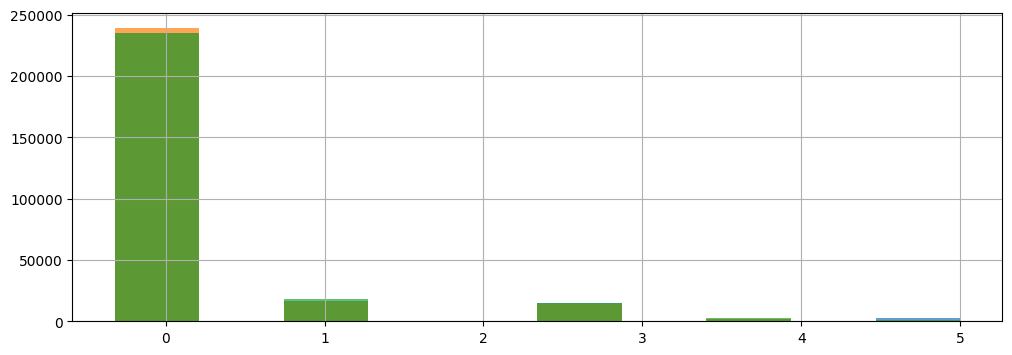

In [62]:
df_train['FEATURE0'].clip(upper=5).hist(figsize=(12, 4), alpha=.7)
df_syn_tvae['FEATURE0'].clip(upper=5).hist(alpha=.7)
df_syn_ctgan['FEATURE0'].clip(upper=5).hist(alpha=.7)

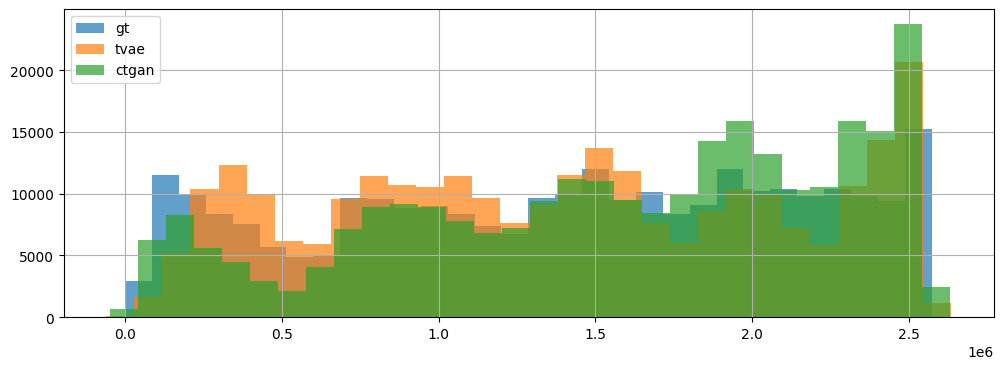

In [63]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn_tvae['TIMESTAMP'].hist(alpha=.7, bins=30)
df_syn_ctgan['TIMESTAMP'].hist(alpha=.7, bins=30)
plt.legend(['gt', 'tvae', 'ctgan'])

In [64]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn_tvae[col].value_counts().rename('TVAE'),
    df_syn_ctgan[col].value_counts().rename('CTGAN')
], axis=1)

,Real,TVAE,CTGAN
0,268474,271341.0,196537
1,2867,NaN,74804


In [65]:
col = 'ACTIONID'
print(df_train[col].nunique())
print(df_syn_tvae[col].nunique())
print(df_syn_ctgan[col].nunique())

271283
191572
195888


In [66]:
col = 'USERID'
print(df_train[col].nunique())
print(df_syn_tvae[col].nunique())
print(df_syn_ctgan[col].nunique())

4932
7273
7473


In [67]:
col = 'TARGETID'
print(df_train[col].nunique())
print(df_syn_tvae[col].nunique())
print(df_syn_ctgan[col].nunique())

97
99
97


### Оценка качества TSTR

У нас данные представляют собой последовательность действий, которые заканчиваются целевым или нет. И правильно было бы их рассматривать как последовательности.

Но здесь, для упрощения сагрегируем по пользователю и посчитаем фичи.

In [68]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def get_features(df):
    agg_dict = {
        'LABEL': ('LABEL', 'max'),
        'cnt': ('LABEL', 'count'),
        'min_ts': ('TIMESTAMP', 'min'),
        'max_ts': ('TIMESTAMP', 'max')
    }
    agg_dict.update({f'mean_{c}': (c, 'mean')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    agg_dict.update({f'max_{c}': (c, 'max')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    df_agg = df.groupby('USERID').agg(**agg_dict).reset_index()
    df_agg['dur'] = df_agg['max_ts'] - df_agg['min_ts']
    del df_agg['max_ts'], df_agg['min_ts']
    return df_agg

In [69]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_tvae_feat = get_features(df_syn_tvae)
df_ctgan_feat = get_features(df_syn_ctgan)
df_train_feat.shape, df_test_feat.shape, df_tvae_feat.shape, df_ctgan_feat.shape

((4932, 12), (2115, 12), (7273, 12), (7473, 12))

In [70]:
df_train_feat.head()

,USERID,LABEL,cnt,mean_FEATURE0,mean_FEATURE1,mean_FEATURE2,mean_FEATURE3,max_FEATURE0,max_FEATURE1,max_FEATURE2,max_FEATURE3,dur
0,0,0,74,-0.319991,-0.023092,0.072931,2.189165,-0.319991,2.108722,1.108826,149.451211,2362371.0
1,1,0,25,-0.319991,-0.130371,0.086743,0.012969,-0.319991,2.108722,0.607805,0.936171,1201293.0
2,2,0,180,0.256688,0.101455,-0.074141,-0.038320,7.768502,2.108722,1.108826,1.337563,2243509.0
3,3,1,6,-0.319991,-0.011631,0.023280,-0.067309,-0.319991,2.108722,0.106784,-0.067309,739000.0
4,4,1,8,-0.319991,0.518457,0.232039,0.860910,-0.319991,2.108722,1.108826,7.157747,1913.0


In [71]:
def eval_model(df_train, df_test, mode):
    X_train = df_train.copy()
    y_train = X_train.pop('LABEL')
    X_test = df_test.copy()
    y_test = X_test.pop('LABEL')
    xgb = XGBClassifier(n_estimators=30, max_depth=5, learning_rate=.1, objective='binary:logistic', verbosity=1)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    metrics = {'mode': mode,
               'cnt_rows_train': y_train.shape[0],
               'cnt_ones_train': (y_train == 1).sum(),
               'F1_train': f1_score(y_train, y_pred_train),
               'F1_test': f1_score(y_test, y_pred_test)}
    return metrics

In [72]:
df_eval = pd.DataFrame([
    eval_model(df_ctgan_feat, df_test_feat, 'TSTR CTGAN'),
    eval_model(df_tvae_feat, df_test_feat, 'TSTR TVAE'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR CTGAN,7473,7305,0.998495,0.679411
1,TSTR TVAE,7273,0,0.000000,0.000000
2,TRTR,4932,2867,0.866609,0.827356


### Ещё модели

#### RTVAE

В работе [Robust VAE for Tabular Data with β Divergence](https://arxiv.org/pdf/2006.08204.pdf) предложили заменить KL-дивергенцию на $\beta$-дивергенцию, что позволяет бороться с выбросами. В обычной KL-дивергенции $log\ p(x_i | z)$ очень чувствителен к выбросам из-за того, что минус логарифм правдоподобия для образцов с низкой вероятностью может быть произвольно большим. $\beta$-дивергенция позволяет существенно снизить влияние выбросов по сравнению с ванильным VAE. При этом также учитываются особенности таблиц - непрерывные и категориальные столбцы.

#### CTAB-GAN

В работе [CTAB-GAN: Effective Table Data Synthesizing](https://arxiv.org/pdf/2102.08369.pdf) собрали успешные приёмы из предыдущих статей:

* условная генерация, для учёта редких категорий и training-by-sampling (как в CTGAN)
* дополнительные функции потерь (как в TableGAN):
	* информационный лосс - штрафует за отклонение статистик (среднее и СКО) в сгенерированных данных от реальных
	* лосс классификатора - параллельно с дискриминатором добавляется дополнительный классификатор, который для каждой строчки предсказывает берёт какую-то заданную метку, предсказывает её же классификатором и определяет разницу между синтезированным и предсказанным значением, что в итоге позволяет минимизировать количество некорректных значений атрибутов (например, предсказание наличие сугубо мужского диагноза, когда пол - женский)

Дополнительно ввели понятие смешанной переменной (mixed variable), когда столбец представляет собой смесь категориального и числового типа, например размер ипотеки имеет яркую моду в нуле для тех, у кого нет ипотеки и вещественное распределение для тех, у кого она есть.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTAB-GAN_mixed_type.png" alt="TVAE arch" width="60%">
<figcaption align = "center"> Image credit: CTAB-GAN paper</figcaption>
</figure>

В mixed-type encoder также используется VGM, при этом мода не сэмплируется а просто выбирается с наибольшей вероятностью. Для смешанных атрибутов, к непрерывным модам добавляются дополнительные дискретные и если значение попадает в дискретную моду, то оно просто не нормализуется. При этом под них заводятся позиции в one-hot векторе $\beta$.

И изменили метод кодирования условных векторов - там используются не только категориальные атрибуты, но и моды вещественных/смешанных атрибутов.

<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w9/CTAB-GAN_cond_vector.png" alt="TVAE arch" width="60%">
<figcaption align = "center"> Image credit: CTAB-GAN paper</figcaption>
</figure>

Плюс для борьбы с длинными хвостами вещественные переменные логарифмируется после сдвига на положительную часть вещественной прямой.

Архитектура генератора и дискриминатора - свёртчные сети, а классификатора - MLP. Классификатор отдельно предобучается на реальных данных, а для подачи туда сгенерированных строк происходит обратное декодирование признаков.

В продолжении [CTAB-GAN+: Enhancing Tabular Data Synthesis](https://arxiv.org/pdf/2204.00401.pdf) перешли на WGAN-GP и добавили Differential Privacy (DP) градиентный спуск.


## Заключение

У нас в данных есть временная составляющая, поэтому правильно рассматривать их как временной ряд с табличными атрибутами, а просто табличные GAN это не учитывают. В дальнейшем попробуем модели для tabular time-series и сравним, насколько они лучше учитывают последовательность событий во времени.

В целом можно сказать, что текущие модели из коробки не очень справились с генерацией выбранного датасета, возможно нужен дополнительный тюнинг параметров сетей. TVAE ранее неплохо показывал себя в других задачах, однако здесь совсем не справился с генерацией целевого атрибута.

## Упражнения

* явно подать значения LABEL на вход генерации CTGAN, в соответствии с реальным распределением
* потюнить параметры сетей
* обучить CTAB-GAN и CTAB-GAN+ на данном датасете и посчитать метрики